## Import All the Necessary Modules ##
### Auxiliary Imports ###

In [1]:
import matplotlib.pyplot as plt

import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

import sklearn.datasets
import sklearn.preprocessing
import sklearn.tree

%matplotlib inline

### FAT Forensics Imports ###

In [2]:
import fatf.utils.data.datasets as fatf_datasets
import fatf.utils.data.augmentation as fatf_augmentation
import fatf.utils.kernels as fatf_kernels
import fatf.utils.distances as fatf_distances

import fatf

20-Jan-25 23:53:16 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


### Define Bikes dataset location ###

In [3]:
bikes_directory = './partial_train_data/station_1_train.csv'

### Load bikes dataset from 1 CSV ###

In [88]:
numerical_columns = (6, 10, 11, 12, 13, 14, 15, 16, 17, 18)
feature_names = ['month', 'weekhour', 'isHoliday', 'windMaxSpeed', 'windDirection', 'temperature', 'relHumidity'
                  'airPressure', 'precipitation']

bikes_data = np.genfromtxt(
    bikes_directory,
    delimiter=',',
    skip_header=1,
    dtype=np.float32,
    usecols=numerical_columns,
    invalid_raise=True)

bikes_target = np.genfromtxt(
    bikes_directory,
    delimiter=',',
    skip_header=1,
    dtype=int,
    usecols=-1,
    invalid_raise=True)

nan_rows = np.isnan(bikes_data).any(axis=1)
bikes_data = bikes_data[~nan_rows]
bikes_target = bikes_target[~nan_rows]

### Change target into classification problem ####
We're going to bin the target variable into [0.0<=x<2.0, 2.0<=x<8.0, 8.0<=x<13.0, 13.0<=x<25.0]

<BarContainer object of 3 artists>

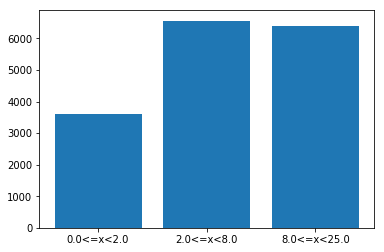

In [89]:
binned_targets = np.digitize(bikes_target, bins=[0.0, 1.0, 4.0, 25.0])
_, counts = np.unique(binned_targets, return_counts=True)
bins = ['0.0<=x<2.0', '2.0<=x<8.0', '8.0<=x<25.0']
plt.bar(bins, counts)

In [75]:
clf_bikes = RandomForestClassifier(n_estimators=100)
clf_bikes.fit(bikes_data, binned_targets)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
bikes_training_predictions = clf_bikes.predict(bikes_data)

bikes_training_accuracy = sklearn.metrics.accuracy_score(
    bikes_target, bikes_training_predictions)

print('Training set *accuracy*: {:.3}.'.format(bikes_training_accuracy))

Training set *accuracy*: 0.123.


### Select Data Point for Explanation ###

In [78]:
data_point = bikes_data[0]
data_point_target = binned_targets[0]

### Build Surrogates ###

In [82]:
local_samples_number = 1000

sampler = fatf_augmentation.NormalSampling(bikes_data)

sampled_data = sampler.sample(data_point, samples_number=local_samples_number)

sampled_data_prediction = clf_bikes.predict_proba(sampled_data)[:, data_point_target]

distance_normal = fatf_distances.euclidean_point_distance(data_point, sampled_data)

# Kernel width is set to the default value in the LIME implementation
kernel_width = 0.75 * np.sqrt(sampled_data.shape[1])
sampled_weights = fatf_kernels.exponential_kernel(distance_normal, width=kernel_width)

#### Linear Model (Ridge Regression) ####

In [80]:
ridge = Ridge(alpha=1, fit_intercept=True)
ridge.fit(sampled_data, sampled_data_prediction, sample_weight=sampled_weights)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [81]:
ridge.coef_

array([ 1.27009256e-10, -8.63601103e-10,  1.60099874e-11,  1.13361367e-09,
        4.30038685e-10,  2.41849509e-10,  7.64490008e-11,  1.04345817e-09,
        1.10394598e-09, -1.11723019e-11])

#### Linear Model with Discretised Features ####

In [84]:
# finish code here

#### Surrogate Decision Tree ####

In [85]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(sampled_data, sampled_data_prediction, sample_weight=sampled_weights)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

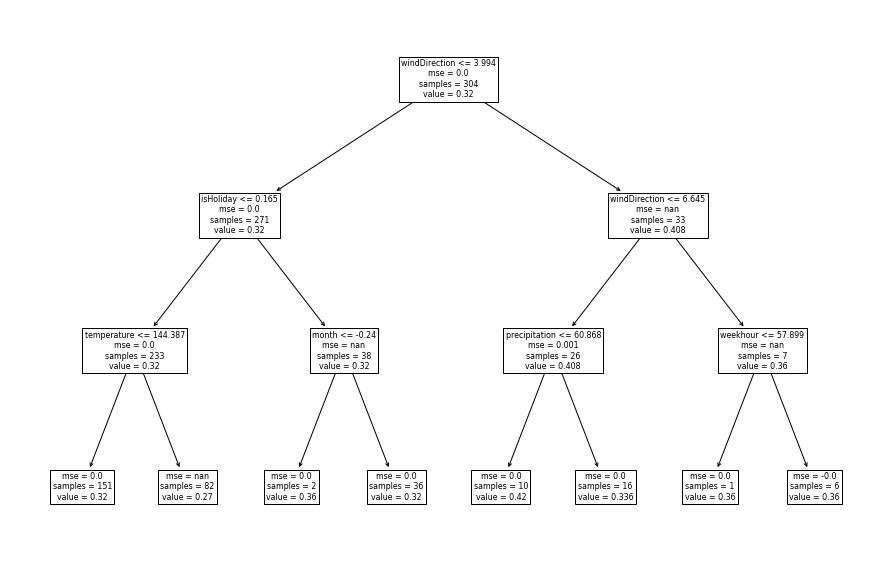

In [90]:
plt.figure(figsize=(15, 10))
tree_text = sklearn.tree.plot_tree(tree, feature_names=feature_names)